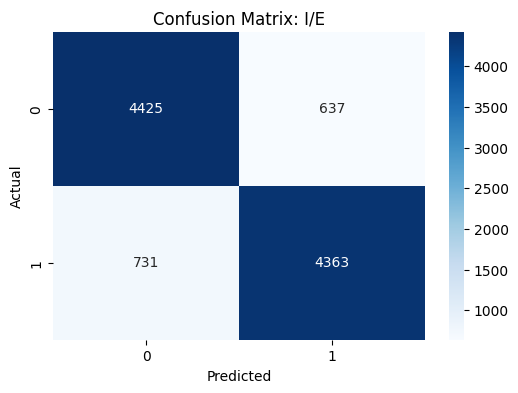

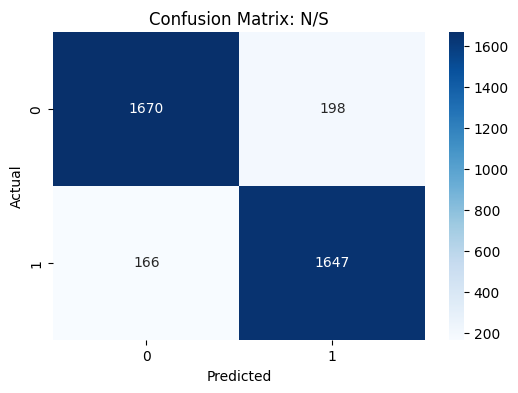

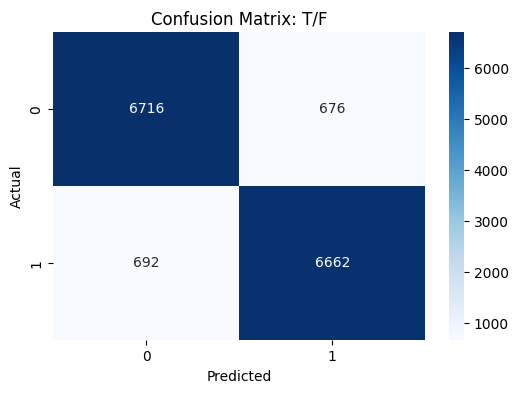

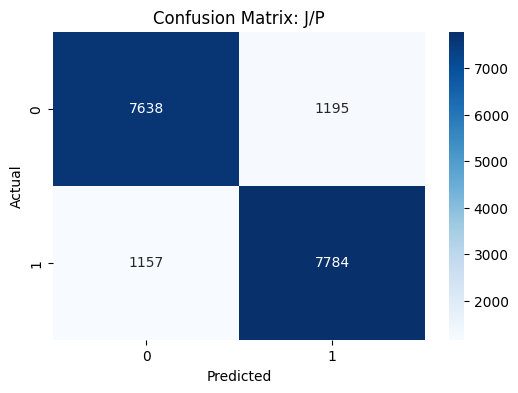

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 시각화 함수 정의
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Confusion Matrix 계산 및 시각화 함수 정의
def calculate_and_plot_confusion(models, X_tests, y_tests, labels):
    for model, X_test, y_test, label in zip(models, X_tests, y_tests, labels):
        y_pred = model.predict(X_test)
        plot_confusion_matrix(y_test, y_pred, title=label)

# 모델과 데이터 리스트 준비
models = [model_ie, model_ns, model_tf, model_jp]
X_tests = [X_test_ie, X_test_ns, X_test_tf, X_test_jp]
y_tests = [y_test_ie, y_test_ns, y_test_tf, y_test_jp]
labels = ["I/E", "N/S", "T/F", "J/P"]

# Confusion Matrix 출력
calculate_and_plot_confusion(models, X_tests, y_tests, labels)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.01,
    n_estimators=200,
    max_depth=5,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64
Accuracy for I_E: 0.8113430484442694
Accuracy for N_S: 0.8285791904373812
Accuracy for T_F: 0.8406347484063474
Accuracy for J_P: 0.8191178125351637
Final MBTI Prediction Accuracy: 0.5574683926197592
Predicted MBTI: INTP


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=200,
    max_depth=10
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64
Accuracy for I_E: 0.8613627412367074
Accuracy for N_S: 0.8856289051888074
Accuracy for T_F: 0.9004475790044758
Accuracy for J_P: 0.8654214020479352
Final MBTI Prediction Accuracy: 0.7603024503379939
Predicted MBTI: ISTJ


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
    model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.1,
    n_estimators=200,
    max_depth=15
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


100%|██████████| 123M/123M [00:01<00:00, 66.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # GPU 활성화: tree_method='gpu_hist'
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist',  # GPU 활성화
        learning_rate=0.1,
        n_estimators=200,
        max_depth=15
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:54:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:55:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:55:09] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


Accuracy for I_E: 0.8631350925561244


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:55:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:55:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for N_S: 0.8799239337136647


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:56:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:57:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for T_F: 0.895564898955649


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:58:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:59:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for J_P: 0.864915044446945
Final MBTI Prediction Accuracy: 0.7592747980050345
Predicted MBTI: ISTP


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # GPU 활성화: tree_method='gpu_hist'
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist',  # GPU 활성화
        learning_rate=0.1,
        n_estimators=200,
        max_depth=13
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:41:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for I_E: 0.8627412367073651


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:42:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for N_S: 0.8820972561803858


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:43:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for T_F: 0.8976671639766717


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:46:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for J_P: 0.8632271857769777
Final MBTI Prediction Accuracy: 0.7596142061150027
Predicted MBTI: ISTP


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# DownSampling 함수 정의
def downsample(df, target_col):
    minority_class_size = df[target_col].value_counts().min()
    df_majority = df[df[target_col] == df[target_col].value_counts().idxmax()]
    df_minority = df[df[target_col] == df[target_col].value_counts().idxmin()]
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=minority_class_size,
        random_state=42
    )
    df_balanced = pd.concat([df_majority_downsampled, df_minority])
    return df_balanced

# 각 차원별 DownSampling 수행
df_ie_balanced = downsample(df, 'I_E')
df_ns_balanced = downsample(df, 'N_S')
df_tf_balanced = downsample(df, 'T_F')
df_jp_balanced = downsample(df, 'J_P')

# DownSampling 후 데이터 확인
print("I_E Balance:\n", df_ie_balanced['I_E'].value_counts())
print("N_S Balance:\n", df_ns_balanced['N_S'].value_counts())
print("T_F Balance:\n", df_tf_balanced['T_F'].value_counts())
print("J_P Balance:\n", df_jp_balanced['J_P'].value_counts())

# 학습 및 평가 함수 정의
def train_and_predict(X_train, y_train, X_test, y_test, label):
    # GPU 활성화: tree_method='gpu_hist'
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='gpu_hist',  # GPU 활성화
        learning_rate=0.1,
        n_estimators=300,
        max_depth=10
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {label}: {accuracy}")
    return model

# 각 차원별 데이터 분할 및 모델 학습
def prepare_and_train(df_balanced, label):
    X_balanced = vectorizer.transform(df_balanced['posts']).toarray()
    y_balanced = df_balanced[label]
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
    model = train_and_predict(X_train, y_train, X_test, y_test, label)
    return model, X_test, y_test

model_ie, X_test_ie, y_test_ie = prepare_and_train(df_ie_balanced, 'I_E')
model_ns, X_test_ns, y_test_ns = prepare_and_train(df_ns_balanced, 'N_S')
model_tf, X_test_tf, y_test_tf = prepare_and_train(df_tf_balanced, 'T_F')
model_jp, X_test_jp, y_test_jp = prepare_and_train(df_jp_balanced, 'J_P')

# 최종 MBTI 예측 함수 정의
def calculate_final_accuracy(X_test, y_test_full):
    predictions = []
    for x in X_test:
        x = x.reshape(1, -1)
        ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
        ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
        tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
        jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
        predictions.append(ie + ns + tf + jp)

    correct_predictions = sum([1 for true, pred in zip(y_test_full, predictions) if true == pred])
    final_accuracy = correct_predictions / len(y_test_full)
    return final_accuracy

# 전체 MBTI 유형 데이터로 예측
X_full_test, y_full_test = vectorizer.transform(df['posts']).toarray(), df['type']
final_accuracy = calculate_final_accuracy(X_full_test, y_full_test)
print("Final MBTI Prediction Accuracy:", final_accuracy)

# 샘플 텍스트 예측
def predict_mbti(text):
    x = vectorizer.transform([text]).toarray()
    ie = 'E' if model_ie.predict(x)[0] == 1 else 'I'
    ns = 'S' if model_ns.predict(x)[0] == 1 else 'N'
    tf = 'F' if model_tf.predict(x)[0] == 1 else 'T'
    jp = 'P' if model_jp.predict(x)[0] == 1 else 'J'
    return ie + ns + tf + jp

sample_text = "I enjoy deep conversations and reflecting on philosophical topics."
predicted_mbti = predict_mbti(sample_text)
print("Predicted MBTI:", predicted_mbti)


Path to dataset files: /root/.cache/kagglehub/datasets/zeyadkhalid/mbti-personality-types-500-dataset/versions/1
I_E Balance:
 I_E
0    25390
1    25390
Name: count, dtype: int64
N_S Balance:
 N_S
0    9201
1    9201
Name: count, dtype: int64
T_F Balance:
 T_F
0    36864
1    36864
Name: count, dtype: int64
J_P Balance:
 J_P
1    44435
0    44435
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:01:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for I_E: 0.8652028357621111


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:01:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:01:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for N_S: 0.886987231730508


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:02:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for T_F: 0.9047877390478773


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:04:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy for J_P: 0.8654214020479352
Final MBTI Prediction Accuracy: 0.7671283245495771
Predicted MBTI: ISTJ


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import kagglehub

# Kaggle 데이터 다운로드
path = kagglehub.dataset_download("zeyadkhalid/mbti-personality-types-500-dataset")
print("Path to dataset files:", path)

# 데이터 로드 및 전처리
df = pd.read_csv(f"{path}/MBTI 500.csv")
df = df.dropna(subset=['type', 'posts'])

# TF-IDF 변환
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.9)
X = vectorizer.fit_transform(df['posts']).toarray()
feature_names = vectorizer.get_feature_names_out()

# 각 차원별 레이블 생성
df['I_E'] = df['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df['N_S'] = df['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df['T_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
df['J_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

# 상대 빈도 계산 함수
def calculate_relative_frequency(X, y, feature_names):
    """
    주어진 데이터와 레이블을 기반으로 단어의 상대 빈도를 계산합니다.
    """
    # 두 그룹으로 데이터 분리
    X_group_0 = X[y == 0]
    X_group_1 = X[y == 1]

    # 각 단어의 빈도 계산
    group_0_word_freq = X_group_0.sum(axis=0) / X_group_0.sum()
    group_1_word_freq = X_group_1.sum(axis=0) / X_group_1.sum()

    # 데이터프레임 생성
    df_freq = pd.DataFrame({
        'non_zero_feature_names': feature_names,
        'group_0_relative_frequency': group_0_word_freq,
        'group_1_relative_frequency': group_1_word_freq
    }).set_index('non_zero_feature_names')

    return df_freq

# WordCloud 생성 및 제목 추가 함수
def generate_wordclouds_with_titles(df, dimension, dimension_name, group_names, feature_names):
    """
    특정 MBTI 차원의 WordCloud를 생성하고 상단에 이름을 포함하여 시각화합니다.
    """
    # 상대 빈도 계산
    df_freq = calculate_relative_frequency(X, df[dimension].values, feature_names)

    # WordCloud 데이터 준비
    group_0_wordcloud_data = df_freq['group_0_relative_frequency'].to_dict()
    group_1_wordcloud_data = df_freq['group_1_relative_frequency'].to_dict()

    # WordCloud 생성
    group_0_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(group_0_wordcloud_data)
    group_1_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(group_1_wordcloud_data)

    # WordCloud 시각화
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(group_0_wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {group_names[0]} ({dimension_name})', fontsize=16, pad=20)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(group_1_wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {group_names[1]} ({dimension_name})', fontsize=16, pad=20)
    plt.axis('off')

    plt.show()

# 모든 차원에 대해 WordCloud 생성 및 시각화
dimensions_with_names = {
    'I_E': ('Introverted (I)', 'Extraverted (E)', 'Introversion/Extraversion'),
    'N_S': ('Intuitive (N)', 'Sensing (S)', 'Intuition/Sensing'),
    'T_F': ('Thinking (T)', 'Feeling (F)', 'Thinking/Feeling'),
    'J_P': ('Judging (J)', 'Perceiving (P)', 'Judging/Perceiving')
}

for dimension, (group_0_name, group_1_name, dimension_name) in dimensions_with_names.items():
    generate_wordclouds_with_titles(df, dimension, dimension_name, (group_0_name, group_1_name), feature_names)


Output hidden; open in https://colab.research.google.com to view.